<a href="https://colab.research.google.com/github/Swayamprakashpatel/Sol_ME/blob/main/Sol_ME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import io
#df = pd.read_csv('/content/drive/My Drive/DE.csv', low_memory=False,)
url = '/content/Data_FP_7.csv'
df = pd.read_csv(url, low_memory=False,) # Run for labeled data
 
#df.fillna('&',inplace=True)
df.drop('DRUG', axis = 1, inplace = True)
df.drop('CARRIER', axis = 1, inplace = True)
df.drop('LogP_D', axis = 1, inplace = True)
print(df.shape)
df.head()
df.dtypes
#df.columns[df.isna().any()].tolist()
dataset = df.values


(1062, 1763)


In [2]:
X = dataset[:,0:1762]

#Y = dataset[:,1762:1763]
# Run this for labeled data
Y = dataset[:,1762:1763]

#Y = np.log(Y) 
#print(X, X.shape,X.dtype)
#print(Y, Y.shape, Y.dtype)
print(Y)

[[6.21]
 [7.81]
 [8.67]
 ...
 [2.36]
 [1.35]
 [2.74]]


In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.2,random_state = 10 )
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state= 10)
import numpy as np
 
X_train = np.asarray(X_train).astype(np.int64)
X_val = np.asarray(X_val).astype(np.int64)
X_test = np.asarray(X_test).astype(np.int64)
Y_train = np.asarray(Y_train).astype(np.int64)
Y_val = np.asarray(Y_val).astype(np.int64)
Y_test = np.asarray(Y_test).astype(np.int64)
 
filepath = '/content/drive/My Drive/SOLModel.hdf5'
 
checkpoint = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mean_absolute_error', mode='min', save_best_only=True, Save_weights_only = False, verbose = 1), 
              tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=75, verbose =1)]
output_nodes = Y.shape[1]
print(output_nodes)


1


In [6]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(512, activation='relu', input_shape=(1762,)),
                             tf.keras.layers.Dense(512, activation='relu'),
                             #tf.keras.layers.Dense(1762, activation='relu'),
                             tf.keras.layers.Dense(output_nodes, activation ='relu')])

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.1), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])
hist = model.fit(X, Y, epochs= 2000, callbacks=[checkpoint],validation_data=(X, Y), batch_size= None)
model.evaluate(X_test, Y_test)
 
# Error Graph

plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
 

train_acc = min(hist.history['root_mean_squared_error'])
val_acc = min(hist.history['val_root_mean_squared_error'])
train_loss = min(hist.history['loss'])
val_loss = min(hist.history['val_loss'])
print('Training RMSE is')
print(train_acc)
print('Validation RMSE is')
print(val_acc)
print('Training loss is')
print(train_loss)
print('Validation loss is')
print(val_loss)



Epoch 1/2000
32/34 [===========================>..] - ETA: 0s - loss: 8857.9365 - mean_absolute_error: 46.8575
Epoch 1: val_mean_absolute_error improved from inf to 55.32594, saving model to /content/drive/My Drive/SOLModel.hdf5
34/34 [==============================] - 1s 23ms/step - loss: 8697.1182 - mean_absolute_error: 46.8925 - val_loss: 7535.9048 - val_mean_absolute_error: 55.3259
Epoch 2/2000
32/34 [===========================>..] - ETA: 0s - loss: 7239.5439 - mean_absolute_error: 51.0916
Epoch 2: val_mean_absolute_error did not improve from 55.32594
34/34 [==============================] - 1s 18ms/step - loss: 7402.4780 - mean_absolute_error: 51.5330 - val_loss: 7227.5073 - val_mean_absolute_error: 55.6000
Epoch 3/2000
30/34 [=========================>....] - ETA: 0s - loss: 7151.5972 - mean_absolute_error: 51.0959
Epoch 3: val_mean_absolute_error improved from 55.32594 to 44.95063, saving model to /content/drive/My Drive/SOLModel.hdf5
34/34 [==============================] - 1s

KeyError: ignored

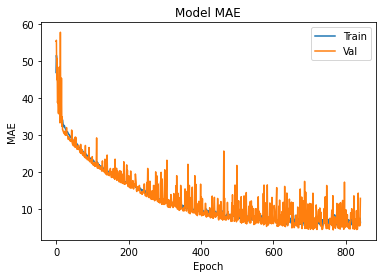

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
plt.savefig('Training.svg', dpi = 600)



In [9]:
train_acc = min(hist.history['mean_absolute_error'])
val_acc = min(hist.history['val_mean_absolute_error'])
train_loss = min(hist.history['loss'])
val_loss = min(hist.history['val_loss'])
print('Training MAE is')
print(train_acc)
print('Validation MAE is')
print(val_acc)
print('Training loss is')
print(train_loss)
print('Validation loss is')
print(val_loss)

Training MAE is
4.699253082275391
Validation MAE is
4.330887794494629
Training loss is
48.83585739135742
Validation loss is
44.251773834228516


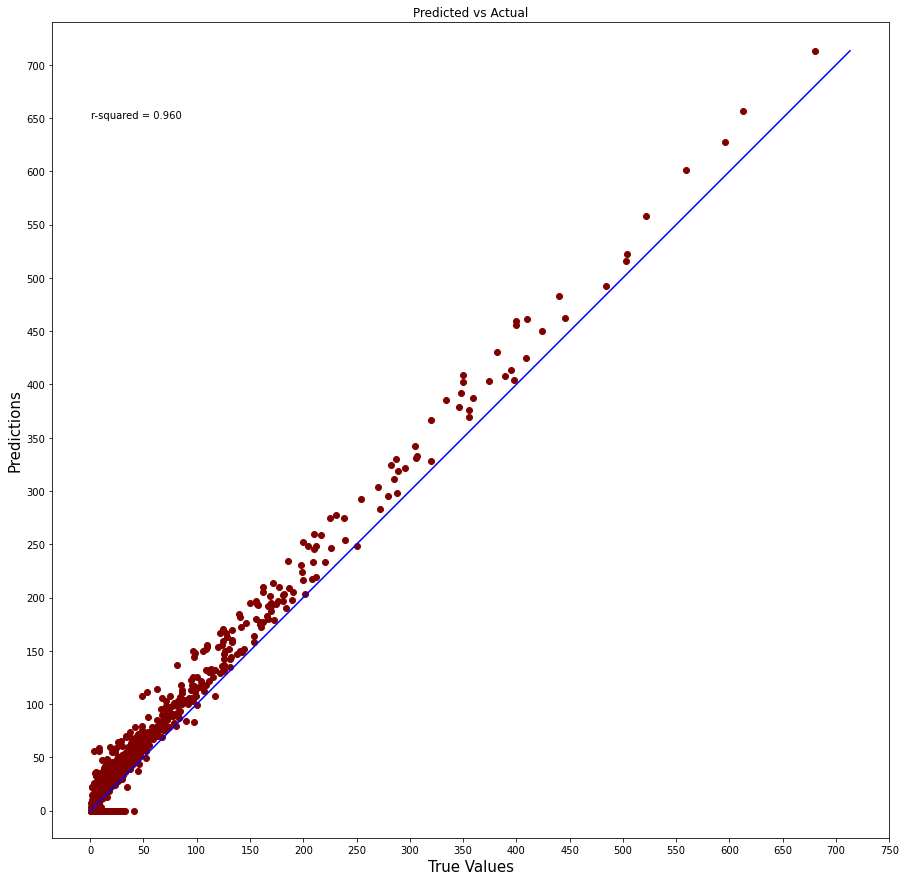

In [8]:
from sklearn.metrics import r2_score
true_value = Y
predicted_value = model.predict(X)

plt.figure(figsize=(15,15))
plt.scatter(true_value, predicted_value, c='maroon')
plt.yscale('linear')
plt.xscale('linear')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Predicted vs Actual')
plt.annotate("r-squared = {:.3f}".format(r2_score(true_value, predicted_value)), (1,650), )
plt.xticks( range(0,800,50) )
plt.yticks( range(0,800,50) )
#plt.show()
plt.savefig('P_A.svg', dpi = 1200)

In [12]:
#@title Insert PubChem Fingerprint of Drug and Carrier (Oil, Surfactant, Cosurfactant)
!pip install pubchempy
import tensorflow as tf
import pandas as pd 
import numpy as np 
import io
from tensorflow import keras
import pubchempy as pcp
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
import time as tm
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1TG-Ati7Za3NUUMP48kPiCoydanpjYCBI',
                                    dest_path='/content/sample_data/Sol_ME.hdf5',
                                    unzip=False)
#Load Model
model = load_model('/content/sample_data/Sol_ME.hdf5', compile= True)


Drug_CID =  24872560#@param {type:"number"}
Excipient_CID =  3033877#@param {type:"number"}


CID_D = pcp.Compound.from_cid(Drug_CID)
CID_E = pcp.Compound.from_cid(Excipient_CID)

FPD = CID_D.cactvs_fingerprint
FPE = CID_E.cactvs_fingerprint
List1 = list(FPD)
List2 = list(FPE)
List = List1 + List2
 
import pandas as pd
t = pd.DataFrame(np.array(List).reshape(-1,len(List)))
 
#@title RUN FOR PREDICTION
 
 
dataset1 = t.values
t.dtype = int
X_Predict = (dataset1[:,0:1762].astype(int))
print(X_Predict)
print(X_Predict.shape)
print(X_Predict.dtype)
 
Y_prediction = model.predict(X_Predict)
 
print(Y_prediction, "mg/ml")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[[1 1 0 ... 0 0 0]]
(1, 1762)
int64
[[27.866291]] mg/ml
